<img src='imgs/header.png' />

The purpose of this notebook is to show you different approaches for reducing your Machine Learning costs, and to, also, explain when to (and not to) use each approach, what kind of considerations you should keep in mind, and what questions you need to answer before choosing a cost saving mechanism. The focus here is not on the the technical implementation (there are complete end-to-end examples for each of the approaches).

# Content

1. **Reducing training cost**:
 - training on spot EC2 instances
 - switching to local training mode
 - SageMaker Debugger Rules  – auto stop bad training jobs
 - SageMaker Experiments – reduces the manual work for model development
 - automated Hyperparameter optimisation (HPO)
 - data Pipe mode
 - SageMaker Profiler
 - AWS MarketPlace - buy ready models

 
2. **Reducing serving cost**:
 - multi-model SageMaker Endpoint
 - SageMaker Endpoint auto scalling
 - serverless inferencing using Lambda and EFS
 - Amazon SageMaker Neo
 - Batch Transform
 - SageMaker Elastic Inference
 - AWS Inferentia


## !!! Please, be sure to read and understand the recommendations on when to use, and, especially, when not to use, each of the presented cost reduction approaches.

In [5]:
import boto3
import os
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import datetime as dt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.multidatamodel import MultiDataModel
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker.content_types import CONTENT_TYPE_CSV

from sagemaker.session import s3_input
from sagemaker.debugger import TensorBoardOutputConfig
from sagemaker.tensorflow import TensorFlow

from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

In [6]:
session = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name

In [7]:
bucket = 'aws-emr-resources-507786327009-us-east-1'
prefix = 'taxidata_v20200426171716'

# 1. Reducing training cost

## 1.1. Training on spot EC2 instances

A Spot Instance is an unused EC2 instance that is available for less than the On-Demand price. Because Spot Instances enable you to request unused EC2 instances at steep discounts, you can lower your Amazon EC2 costs significantly. The hourly price for a Spot Instance is called a Spot price. More info here - https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-spot-instances.html.

In [9]:
!mkdir cifar10
!python generate_cifar10_tfrecords.py --data-dir cifar10
datasets = session.upload_data(path='cifar10', key_prefix='datasets/cifar10-dataset')

In [ ]:
datasets

In [11]:
job_folder      = 'jobs'
dataset_folder  = 'datasets'

train_path = f'{datasets}/train'
val_path   = f'{datasets}/validation'
eval_path  = f'{datasets}/eval'

In [12]:
hyperparams={'epochs'       : 100,
             'learning-rate': 0.01,
             'batch-size'   : 256,
             'weight-decay' : 2e-4,
             'momentum'     : 0.9,
             'optimizer'    : 'adam',
             'model-type'   : 'custom'}

In [21]:
output_path = f's3://{bucket}/jobs'
job_name    = f'tensorflow-spot-{time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())}'

tf_estimator = TensorFlow(entry_point = 'cifar10-training-sagemaker.py', 
                          source_dir = 'code',
                          output_path = f'{output_path}/',
                          code_location = output_path,
                          checkpoint_s3_uri = f'{output_path}/{job_name}/checkpoints',
                          role = role,
                          train_instance_count = 1, 
                          train_instance_type = 'ml.p3.2xlarge',
                          framework_version = '1.15', 
                          py_version = 'py3',
                          script_mode = True,
                          train_use_spot_instances = True,
                          debugger_hook_config = False,
                          train_max_wait = 7200,
                          train_max_run = 3600,
                          sagemaker_session = session,
                          hyperparameters = hyperparams)

print(job_name)

tensorflow-spot-2020-08-25-08-59-02


In [23]:
tf_estimator.fit({'training' : train_path, 'validation': val_path, 'eval' : eval_path}, \
                 job_name = job_name, wait = True)

<left><img src='imgs/spotec2training.png' /></left>

### 1.1.1. When to use this approach?

**DO NOT USE WHEN**

- Do not train models on spot EC2 instances in the cases when your training job should 100% finish. The nature of Spot EC2 isntaces is that they can be stopped at any point (although that happens very rarely).

### 1.1.2. Complete end-to-end example

- https://github.com/shashankprasanna/sagemaker-spot-training

### 1.2.3. Additional notes on training with spot EC2 instances
- You can continue training a model in the rare occasions when your training jobs is be stopped.
- Add checkpoints to your Estimator (as in the example above) to make sure that when you restart training it will pick up from the point it was stopped, rather than start the training from the beginning.
- Restarting of a stopped job is not automatic but you can automate it through the CloudWatch logs.

<br/>

## 1.2. Local training mode

In [99]:
 xgb_local = sagemaker.estimator.Estimator(get_image_uri(region, 'xgboost', '1.0-1'),
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='local', # change to local
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.local.local_session.LocalSession(), # change to local
                                    hyperparameters=xgb_hyperparameters)

	get_image_uri(region, 'xgboost', '1.0-1').


In [ ]:
xgb_local.fit({'train': 'file://taxidata/traintaxi.csv'})
# Can use local file or S3 files
#xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

### 1.2.1. When to use this approach?

- You already have SageMaker Notebook instance running.
- For tests. Not in production.
- You, however, cannot pick what instance type to use of training. For example, if the SageMaker notebooks was started with a specific instance type that does not support GPU, then you cannot turn on GPU on local training. You can only use the original instance type. To change the instance type you have to stop the Notebook (which will delete all variables).

<br/>

## 1.3. SageMaker Debugger Rules

Amazon SageMaker Debugger provides full visibility into model training by monitoring, recording, analyzing, and visualizing training process tensors. A tensor is a high-dimensional array of machine learning and deep learning metrics such as weights, gradients, and losses. It is a collection of metrics that's continuously updated during the backpropagation and optimization process of training deep learning models. More info - https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html.

<left><img src='imgs/debuggerarchitecture.png' width=850/></left>

<br/>

### Caution: bad hyperparameters!

In [3]:
xgb_hyperparameters = {
    "max_depth": "9",
    "eta": "1",
    "gamma": "7",
    "min_child_weight": "6",
    "subsample": "0.8",
    "silent": "0",
    "objective": "reg:squarederror",
    "num_round": "400",
    "eval_metric":"rmse"
}

In [8]:
save_interval = 3

sm_debugger_rules = [
    Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
]

In [45]:
sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost', '0.90-2')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess,
                                    rules=sm_debugger_rules,
                                    hyperparameters=xgb_hyperparameters)

	get_image_uri(region, 'xgboost', '1.0-1').


In [46]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [47]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-09-07 06:56:47 Starting - Starting the training job...
2020-09-07 06:56:49 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*
****************************************
.........
2020-09-07 06:58:36 Starting - Preparing the instances for training......
2020-09-07 06:59:45 Downloading - Downloading input data
2020-09-07 06:59:45 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:roo

**Total rounds from hyperparams: 400. Stopped on round 302.**

### 1.3.1. When to use this approach?

- As part of automated ML workloads, e.g.:
    - CI/CD pipelines
    - Event driven ML (for example a change in the data stored in a S3 bucket or a SQL database can automatically trigger job training using the newly available data).You do not need a manual intervention or constant human monitoring - the whole logic can be completely automated.

### 1.3.2. Complete end-to-end example
- https://github.com/borisbanushev/AWSGlue-SageMakerDebugger
- https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-debugger/tensorflow_action_on_rule/tf-mnist-stop-training-job.ipynb

<br/>

## 1.4. SageMaker Experiments

Amazon SageMaker Experiments is a capability of Amazon SageMaker that lets you organize, track, compare, and evaluate your machine learning experiments.

Machine learning is an iterative process. You need to experiment with multiple combinations of data, algorithm and parameters, all the while observing the impact of incremental changes on model accuracy. Over time this iterative experimentation can result in thousands of model training runs and model versions. This makes it hard to track the best performing models and their input configurations. It’s also difficult to compare active experiments with past experiments to identify opportunities for further incremental improvements.

SageMaker Experiments automatically tracks the inputs, parameters, configurations, and results of your iterations as trials. You can assign, group, and organize these trials into experiments. SageMaker Experiments is integrated with Amazon SageMaker Studio providing a visual interface to browse your active and past experiments, compare trials on key performance metrics, and identify the best performing models. More info - https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html.

### 1.4.1. When to use this approach?

- Explore data
- Feasibility check

### 1.4.2. Complete end-to-end example

- https://github.com/aws/sagemaker-experiments

<br/>

## 1.5. Automated Hyperparameter optimisation

Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. More info - https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html.

### 1.5.1. Complete end-to-end example

- https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning

<br/>

## 1.6. Data Pipe mode

With Pipe input mode, your dataset is streamed directly to your training instances instead of being downloaded first. This means that your training jobs start sooner, finish quicker, and need less disk space. Amazon SageMaker algorithms have been engineered to be fast and highly scalable. This blog post describes Pipe input mode, the benefits it brings, and how you can start leveraging it in your training jobs. More info - https://aws.amazon.com/blogs/machine-learning/using-pipe-input-mode-for-amazon-sagemaker-algorithms.

<img src='imgs/pipe.gif' />

**Benefits of Pipe mode**:
- Quicker startup times because the data is being streamed instead of being downloaded to your training instances.
- Higher I/O throughputs due to our high-performance streaming agent.
- Virtually limitless data processing capacity.

### 1.6.1. When to use this approach?

- You have huge training dataset.

### 1.6.2. End to end example
- https://aws.amazon.com/blogs/machine-learning/accelerate-model-training-using-faster-pipe-mode-on-amazon-sagemaker/
- https://aws.amazon.com/blogs/machine-learning/using-pipe-input-mode-for-amazon-sagemaker-algorithms/

<br/>

## 1.7. SageMaker Profiler (preview)

### !!! UNDER NDA, DO NO COMMUNICATE EXTERNALLY

How to decide which is the right instance type?

Do you need GPU or not?

<img src='imgs/profiler.png' />

## 1.8. AWS MarketPlace - buy ready models

AWS Marketplace is a digital catalog with thousands of software listings from independent software vendors that make it easy to find, test, buy, and deploy software that runs on AWS. More info - https://aws.amazon.com/marketplace.

**Machine Learning (765 results)**

<img src='imgs/awsmarketplace.png' />

### 1.8.1. When to use this approach?

- not specific or domain that needs feature negineering
- exploring solutions

# 2. Reducing serving cost

## 2.1. Multi-model SageMaker Endpoint

To create an endpoint that can host multiple models, use multi-model endpoints. Multi-model endpoints provide a scalable and cost-effective solution to deploying large numbers of models. They use a shared serving container that is enabled to host multiple models. This reduces hosting costs by improving endpoint utilization compared with using single-model endpoints. More info - https://docs.aws.amazon.com/sagemaker/latest/dg/multi-model-endpoints.html.

<left><img src='imgs/multimodelarchitecture.png' width=500 /></left>

In [13]:
model = xgb.create_model(role=role, image=get_image_uri(region, 'xgboost', '1.0-1'))

	get_image_uri(region, 'xgboost', '1.0-1').


In [26]:
model_data_prefix = 's3://aws-emr-resources-507786327009-us-east-1/taxidata_v20200426171716/output/sagemaker-xgboost-2020-04-26-17-28-28-830/'

In [34]:
mme = MultiDataModel(name='multi-model-xgb2',
                     model_data_prefix=model_data_prefix,
                     model=model,# passing our model - passes container image needed for the endpoint
                     sagemaker_session=session)

In [36]:
predictor = mme.deploy(initial_instance_count=1,
                       instance_type='ml.m4.xlarge',
                       endpoint_name='multi-model-xgb2-new')

-----------------!

In [38]:
list(mme.list_models())

['output/model.tar.gz']

In [40]:
predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer
predictor.content_type = CONTENT_TYPE_CSV
predictor.accept = CONTENT_TYPE_CSV

In [ ]:
predicted_value = predictor.predict([x for x in range(19)], target_model='model.tar.gz')

### 2.1.1. When to use this approach?

- You have many, infrequently called, models that you can pack together.

### 2.1.2. End to end example
- https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/multi_model_xgboost_home_value/xgboost_multi_model_endpoint_home_value.ipynb

<br/>

## 2.2. **SageMaker Endpoint auto scalling**

Amazon SageMaker supports automatic scaling (autoscaling) for your hosted models. Autoscaling dynamically adjusts the number of instances provisioned for a model in response to changes in your workload. When the workload increases, autoscaling brings more instances online. When the workload decreases, autoscaling removes unnecessary instances so that you don't pay for provisioned instances that you aren't using. More info - https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html and https://aws.amazon.com/blogs/machine-learning/save-on-inference-costs-by-using-amazon-sagemaker-multi-model-endpoints/.

### 2.2.1. When to use this approach?

- Irregular and spiky demand but also need low latency

<br/>

## 2.3. **Serverless inferencing using Lambda functions and Amazon EFS**

In [51]:
image_url = 'https://images.pexels.com/photos/310983/pexels-photo-310983.jpeg?auto=compress&w=900&h=595'

In [52]:
!aws efs describe-file-systems

{
    "FileSystems": [
        {
            "OwnerId": "507786327009",
            "CreationToken": "LambdaEFSMLEFS85B0E724-WxQ8JB2tXicX",
            "FileSystemId": "fs-fd04a37f",
            "CreationTime": 1598468644.0,
            "LifeCycleState": "available",
            "Name": "LambdaEFSMLDemo/LambdaEFSMLEFS",
            "NumberOfMountTargets": 2,
            "SizeInBytes": {
                "Value": 12288,
                "Timestamp": 1599466918.0,
                "ValueInIA": 0,
                "ValueInStandard": 12288
            },
            "PerformanceMode": "generalPurpose",
            "Encrypted": false,
            "ThroughputMode": "provisioned",
            "ProvisionedThroughputInMibps": 10.0,
            "Tags": [
                {
                    "Key": "Name",
                    "Value": "LambdaEFSMLDemo/LambdaEFSMLEFS"
                }
            ]
        }
    ]
}


Image downloaded to /tmp/tmpnaqpm725.jpg.


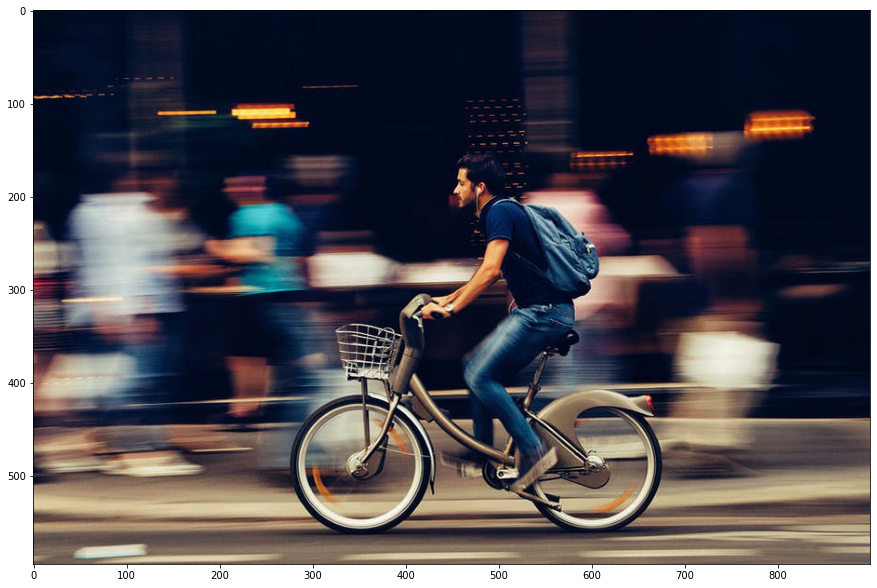

In [53]:
from utils import download_and_resize_image
downloaded_image_path = download_and_resize_image(image_url, 900, 595, True)

In [54]:
import boto3
import json
function_arn = "LambdaEFSMLDemo-LambdaEFSMLExecuteInference17332C2-1MKL9LJ6SNZDM"

lambda_client = boto3.client('lambda')

payload = '{"url": "' + image_url + '" }'

response = lambda_client.invoke(
    FunctionName=function_arn,
    InvocationType='RequestResponse',
    Payload=payload.encode('utf-8')
)

result = json.loads(response['Payload'].read())

<left><img src='imgs/bikelambda.png' width=700/></left>

### 2.3.1. When to use this approach?

Use Lambda+EFS inferencing (as opposed to the SageMaker Endpoints) when:
- You have infrequently used model,
- Irregular and spiky demand,
- You don't need extemely low latency (as Lambdas can be a little slower than SageMaker Endpoints),
- The volume of inferencing data and the model are not huge - so not very suitable for extremely large deep learning models (or large inferencing data sets).

### 2.3.2. Cost Comparisson

1. Lambda - $0.20 per 1M requests, and cost per GB-s (more info here - https://aws.amazon.com/lambda/pricing)

2. *ml.t2.2xlarge* instance (with 8 vCPU, 32 GiB) costs USD 0.5197 per hour, or **USD 386.65** per month.

If you allocated 2,048 MB of memory to your function, executed it 3 million times in one month, and it ran for 1 second each time - cost is **USD 186.66**.

<left><img src='imgs/lambdacost.png' width=800/></left>

### 2.3.3. Complete end-to-end demo

- https://aws.amazon.com/blogs/compute/building-deep-learning-inference-with-aws-lambda-and-amazon-efs/

## 2.4. Amazon SageMaker Neo

SageMaker Neo is a service that optimizes deep learning models for specific infrastructure deployments by reducing the memory imprint which can result in upto double the execution speed. More info - https://aws.amazon.com/blogs/machine-learning/increasing-performance-and-reducing-the-cost-of-mxnet-inference-using-amazon-sagemaker-neo-and-amazon-elastic-inference/.

SageMaker Neo uses deep learning to find code optimizations for specific hardware and deep learning frameworks that allow models to perform at up to twice the speed with no loss in accuracy. Furthermore, by reducing the code base for deep learning networks to only the code required to make predictions, SageMaker Neo reduces the memory footprint for models by up to 10 times. SageMaker Neo can optimize models for a variety of platforms, which makes tuning a model for multiple deployments simple.

<left><img src='imgs/smneo.gif' /></left>

### 2.4.1. Complete end-to-end example:
- https://github.com/dheepanr/MxNet-Sagemaker-Deployments

## 2.5. Batch Transform


Use batch transform when you need to do the following:

- Preprocess datasets to remove noise or bias that interferes with training or inference from your dataset.
- Get inferences from large datasets.
- Run inference when you don't need a persistent endpoint.
- Associate input records with inferences to assist the interpretation of results.

*More info*
- https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html
- https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html.

When a batch transform job starts, SageMaker initializes compute instances and distributes the inference or preprocessing workload between them. Batch Transform partitions the Amazon S3 objects in the input by key and maps Amazon S3 objects to instances. When you have multiples files, one instance might process input1.csv, and another instance might process the file named input2.csv.

<left><img src='imgs/batch-transform-v2.png' width=800 /></left>

### 2.5.1 Complete end-to-end demo

- https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_batch_transform/introduction_to_batch_transform/batch_transform_pca_dbscan_movie_clusters.ipynb

## 2.6. SageMaker Elastic Inference

By using Amazon Elastic Inference (EI), you can speed up the throughput and decrease the latency of getting real-time inferences from your deep learning models that are deployed as Amazon SageMaker hosted models, but at a fraction of the cost of using a GPU instance for your endpoint. EI allows you to add inference acceleration to a hosted endpoint for a fraction of the cost of using a full GPU instance. Add an EI accelerator in one of the available sizes to a deployable model in addition to a CPU instance type, and then add that model as a production variant to an endpoint configuration that you use to deploy a hosted endpoint. You can also add an EI accelerator to a Amazon SageMaker notebook instance so that you can test and evaluate inference performance when you are building your models. More info - https://docs.aws.amazon.com/sagemaker/latest/dg/ei.html.

### 2.6.1. When to use this approach?

- Large deep learning models with infrequent, spiky demand.

<br/>

## 2.7. AWS Inferentia

AWS Inferentia is Amazon's first custom silicon designed to accelerate deep learning workloads and is part of a long-term strategy to deliver on this vision. Amazon EC2 Inf1 instances based on AWS Inferentia chips deliver up to 30% higher throughput and up to 45% lower cost per inference than Amazon EC2 G4 instances, which were already the lowest cost instance for machine learning inference available in the cloud. More info - https://aws.amazon.com/machine-learning/inferentia.